In [1]:
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path

data_path = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/scenicornot.metadata.csv'
image_folder = Path('/home/ubuntu/landscape-aesthetics/data/external/scenicornot') 

# Check if the data path exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data file not found at {data_path}")

#read dataset
data = pd.read_csv(data_path)

# Check if the root directory exists
root_dir = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/'
if not os.path.exists(root_dir):
    raise FileNotFoundError(f"Root directory not found at {root_dir}")

# 预处理数据集，移除无效路径
valid_files = []
missing_files = []
for idx in range(len(data)):
    img_name = data.iloc[idx]['filename']
    image_path = image_folder / Path(img_name)
    if image_path.exists():
        valid_files.append(idx)
    else:
        missing_files.append(image_path)

if missing_files:
    print(f"Missing {len(missing_files)} files:")
    for file in missing_files:
        print(file)

# 只保留有效的文件记录
valid_data = data.iloc[valid_files].reset_index(drop=True)

# for test 10 images
sampled_data = valid_data.sample(n=100, random_state=42).reset_index(drop=True)
print("Sampled filenames:")
print(sampled_data['filename'])

class ScenicDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx]['filename']) # combine root address with filename
        image_path = self.root_dir / Path(img_name)
        # print(f"Loading image: {image_path}")  # 调试信息，打印图片路径

        try:
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            print(f"File not found: {image_path}, skipping.")
            return None, None
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None, None
            
        rating = self.data_frame.iloc[idx]['average']
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(rating, dtype=torch.float32)

# centered crop 256*256
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

# Create the dataset
image_dataset = ScenicDataset(data_frame=sampled_data,
                              root_dir=image_folder,
                              transform=data_transforms)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

# Create data loaders
def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None and isinstance(x[0], torch.Tensor), batch))
    return torch.utils.data.dataloader.default_collate(batch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn) 
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Print the sizes of the training and validation set
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")

# Print filenames in train and validation loaders
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i} train filenames:")
    for j, img in enumerate(images):
        print(train_loader.dataset.indices[j])

for i, (images, labels) in enumerate(val_loader):
    print(f"Batch {i} validation filenames:")
    for j, img in enumerate(images):
        print(val_loader.dataset.indices[j])

Missing 1 files:
/home/ubuntu/landscape-aesthetics/data/external/scenicornot/photos/76/41/764143_e860c8c4.jpg
Sampled filenames:
0            photos/80/03/800369_5a759ab5.jpg
1            photos/68/48/684818_cdb3cafd.jpg
2            photos/27/46/274691_0e61791f.jpg
3            photos/00/54/005438_63918fe8.jpg
4     geophotos/01/07/80/1078056_a80d507d.jpg
                       ...                   
95           photos/00/66/006690_ab326708.jpg
96           photos/78/91/789136_742d0f1b.jpg
97           photos/67/03/670391_831572d3.jpg
98           photos/40/74/407403_42c623de.jpg
99           photos/90/29/902989_a0f5a913.jpg
Name: filename, Length: 100, dtype: object
Training set size: 80
Validation set size: 20
Batch 0 train filenames:
2
59
68
80
19
26
73
74
69
70
60
25
30
50
41
45
62
3
97
10
9
88
90
12
44
31
75
34
85
24
40
38
Batch 1 train filenames:
2
59
68
80
19
26
73
74
69
70
60
25
30
50
41
45
62
3
97
10
9
88
90
12
44
31
75
34
85
24
40
38
Batch 2 train filenames:
2
59
68
80
19
2

In [2]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

# utilise ResNet50 to extract deep features
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNetFeatureExtractor, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # Remove the last fully connected layer

    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)
        return features.squeeze()

feature_extractor = ResNetFeatureExtractor()
feature_extractor.eval()

# define a simple regression model
# class RegressionModel(nn.Module):
#     def __init__(self, input_dim):
#         super(RegressionModel, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 1)
#         )

#     def forward(self, x):
#         return self.fc(x)

# a more complex one
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        return self.fc(x)

Epoch 1/30, Loss: 25.453787994384765
Validation Loss: 20.18155288696289
Epoch 2/30, Loss: 25.04315757751465
Validation Loss: 20.914512634277344
Epoch 3/30, Loss: 25.71758155822754
Validation Loss: 21.9661922454834
Epoch 4/30, Loss: 24.540903854370118
Validation Loss: 22.550750732421875
Epoch 5/30, Loss: 24.231209564208985
Validation Loss: 22.891035079956055
Epoch 6/30, Loss: 24.48467597961426
Validation Loss: 23.658496856689453
Epoch 7/30, Loss: 24.48251266479492
Validation Loss: 22.815284729003906
Epoch 8/30, Loss: 22.327134323120116
Validation Loss: 22.917728424072266
Epoch 9/30, Loss: 23.51714630126953
Validation Loss: 22.814409255981445
Epoch 10/30, Loss: 23.21064910888672
Validation Loss: 22.780961990356445
Epoch 11/30, Loss: 24.12825241088867
Validation Loss: 22.32754135131836
Epoch 12/30, Loss: 23.437947463989257
Validation Loss: 22.311532974243164
Epoch 13/30, Loss: 24.566193771362304
Validation Loss: 22.32670021057129
Epoch 14/30, Loss: 24.92972755432129
Validation Loss: 22.44

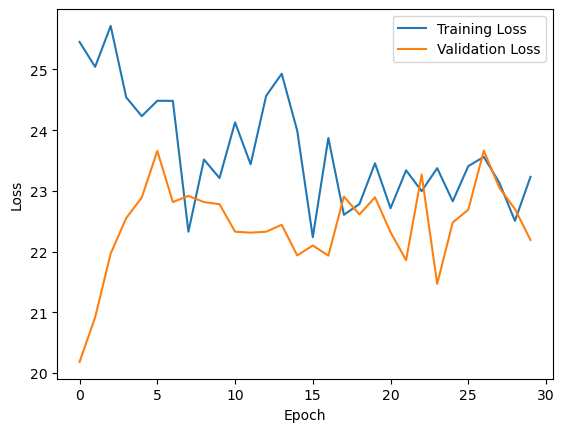

In [4]:
import matplotlib.pyplot as plt

def train_model(feature_extractor, model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            if images is None:  # skip invalid images
                    continue
            features = feature_extractor(images).view(images.size(0), -1)# 添加 .view 以确保特征形状正确
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                if images is None:  # skip invalid images
                    continue
                features = feature_extractor(images).view(images.size(0), -1)
                outputs = model(features)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item() * images.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Validation Loss: {val_loss}')
        
        scheduler.step()  # Update learning rate
    
    return train_losses, val_losses


# Initialize feature extractor and regression model
feature_extractor = ResNetFeatureExtractor()
feature_extractor.eval()  # Set the feature extractor to evaluation mode
input_dim = 2048  # ResNet50 feature dimension
model = RegressionModel(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate scheduler

# training model
train_losses, val_losses = train_model(feature_extractor, model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30)

# Plot training and validation loss
plt.figure()
plt.plot(range(30), train_losses, label='Training Loss')
plt.plot(range(30), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [5]:
# evaluate
def evaluate_model(feature_extractor, model, test_loader):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            #print("Evaluating batch...")
            features = feature_extractor(images).view(images.size(0), -1)
            outputs = model(features)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item() * images.size(0)
    
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss}')
    return test_loss

test_loss = evaluate_model(feature_extractor, model, val_loader)
# # save the model
# torch.save(model.state_dict(), 'complex_regression_model.pth')
# print("Model saved to complex_regression_model.pth")

Test Loss: 22.630878448486328
